In [1]:
!pip install pyspark==3.0.1 py4j==0.10.9

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.2/204.2 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 5.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612223 sha256=3bfbaf9237da33447616d7bc930b7bd5e3f60b8a3dc4e2fb271fa5c85fd2bee6
  Stored in directory: /root/.cache/pip/wheels/19/b0/c8/6cb894117070e130fc44352c2a13f15b6c27e440d04a84fb48
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark_Tutorial')\
        .getOrCreate()

In [7]:
from google.colab import files
uploaded = files.upload()

#Прочитайте CSV файл spark.read.csv()

data = spark.read.csv(
    'bestsellersWithCategories.csv',
    sep=',',
    header=True,
)
#2.	Вивести схему даних за допомогою PrintSchema.
data.printSchema()

Saving bestsellersWithCategories.csv to bestsellersWithCategories.csv
root
 |-- Name: string (nullable = true)
 |-- Author: string (nullable = true)
 |-- User Rating: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Genre: string (nullable = true)



In [10]:
#3.	Вивести назви стовпців і типи даних за допомогою dtypes
data.dtypes

[('Name', 'string'),
 ('Author', 'string'),
 ('User Rating', 'string'),
 ('Reviews', 'string'),
 ('Price', 'string'),
 ('Year', 'string'),
 ('Genre', 'string')]

In [16]:
#4.	Виведіть перші п'ять рядків (використовується метод head)
data.head(5)

[Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating='4.7', Reviews='17350', Price='8', Year='2016', Genre='Non Fiction'),
 Row(Name='11/22/63: A Novel', Author='Stephen King', User Rating='4.6', Reviews='2052', Price='22', Year='2011', Genre='Fiction'),
 Row(Name='12 Rules for Life: An Antidote to Chaos', Author='Jordan B. Peterson', User Rating='4.7', Reviews='18979', Price='15', Year='2018', Genre='Non Fiction'),
 Row(Name='1984 (Signet Classics)', Author='George Orwell', User Rating='4.7', Reviews='21424', Price='6', Year='2017', Genre='Fiction'),
 Row(Name='5,000 Awesome Facts (About Everything!) (National Geographic Kids)', Author='National Geographic Kids', User Rating='4.8', Reviews='7665', Price='12', Year='2019', Genre='Non Fiction')]

In [17]:
#5.	Вивести перший рядок за допомогою first()
data.first()

Row(Name='10-Day Green Smoothie Cleanse', Author='JJ Smith', User Rating='4.7', Reviews='17350', Price='8', Year='2016', Genre='Non Fiction')

In [18]:
#6.	Зробіть опис датасету за допомогою describe()
data.describe()

DataFrame[summary: string, Name: string, Author: string, User Rating: string, Reviews: string, Price: string, Year: string, Genre: string]

In [20]:
#7.	Виведіть список стовпців за допомогою columns()
data.columns

['Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'Genre']

In [21]:
#8.	Виведіть загальну кількість рядків даних за допомогою count()
data.count()

550

In [36]:
#9.	Перевірте, чи у всіх рядків вистачає даних. Якщо є пропуски, замінить їх на NaN, потім тип даних на числовий.
from pyspark.sql.functions import col, when

for column in data.columns:
    data = data.withColumn(column, when(col(column).isNull(), 'NaN').otherwise(col(column)))



In [41]:
# 10. Замініть комірки з пропущеними значенями на середні за стовпцем та змініть тип даних на float
for column in data.columns:
    data = data.withColumn(column, when(col(column) == 'NaN', None).otherwise(col(column)))

for column in data.columns[2:]:
    mean_value = data.selectExpr(f'avg(`{column}`)').collect()[0][0]
    data = data.withColumn(column, when(col(column).isNull(), mean_value).otherwise(col(column).cast('float')))


In [43]:
#11.	Змініть назви всіх колонок: назва з маленької букви, без пробілів через підкреслення.
from pyspark.sql.functions import col

data = data.toDF(*[column.lower().replace(' ', '_') for column in data.columns])


In [44]:
data = data.toDF('name', 'author', 'user_rating', 'reviews', 'price', 'year', 'genre')

In [46]:
# 13. Знайдіть автора з найвищим рейтингом
highest_rating_author = data.orderBy(col("user_rating").desc()).select("author").first()[0]
print("Автор з найвищим рейтингом:", highest_rating_author)

Автор з найвищим рейтингом: Bill Martin Jr.


In [48]:
# 14. Знайдіть автора з найнижчим рейтингом
lowest_rating_author = data.orderBy(col("user_rating").asc()).select("author").first()[0]
print("Автор з найнижчим рейтингом:", lowest_rating_author)

Автор з найнижчим рейтингом: J.K. Rowling


In [49]:
# 15. Знайдіть автора з найбільшою кількість рецензій
most_reviews_author = data.orderBy(col("reviews").desc()).select("author").first()[0]
print("Автор з найбільшою кількістю рецензій:", most_reviews_author)

Автор з найбільшою кількістю рецензій: Delia Owens


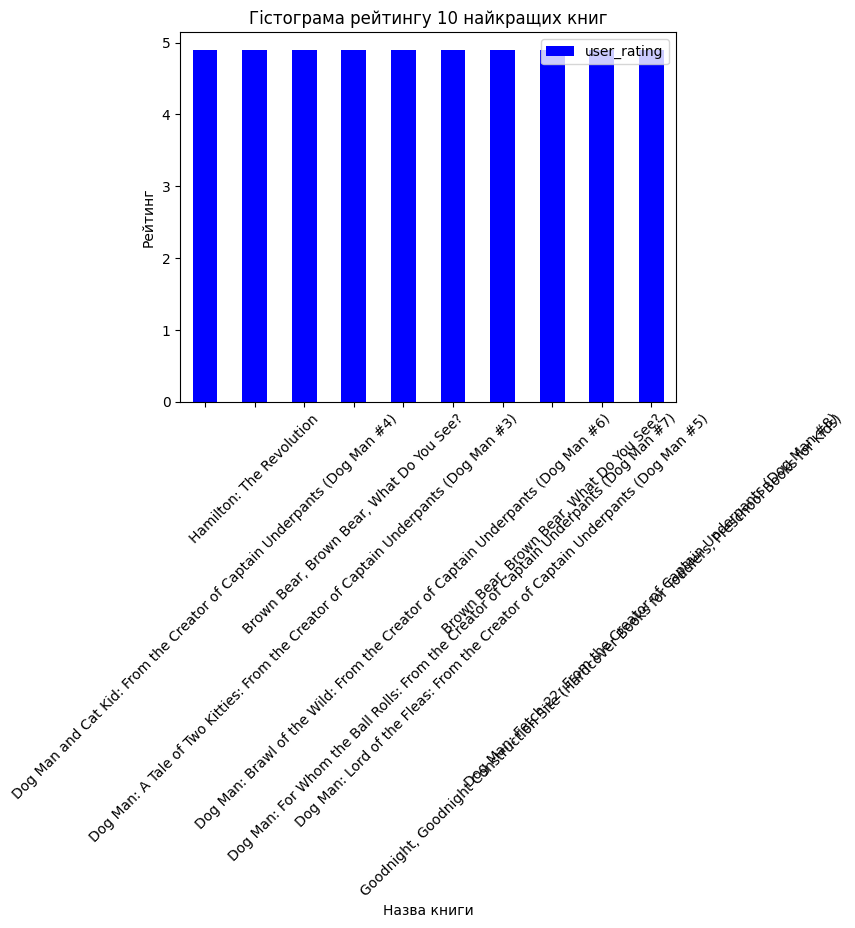

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
# 16. Побудуйте гістограму рейтингу 10 найкращих книг
top_10_books = data.orderBy(col("user_rating").desc()).limit(10).toPandas()
top_10_books.plot(kind='bar', x='name', y='user_rating', color='blue')
plt.xlabel('Назва книги')
plt.ylabel('Рейтинг')
plt.title('Гістограма рейтингу 10 найкращих книг')
plt.xticks(rotation=45)
plt.show()

In [52]:
# 17. Побудуйте матрицю кореляції для стовпчиків 'user_rating', 'reviews', 'price'.
correlation_matrix = data.select('user_rating', 'reviews', 'price').toPandas().corr()
print(correlation_matrix)

             user_rating   reviews     price
user_rating     1.000000 -0.001729 -0.133086
reviews        -0.001729  1.000000 -0.109182
price          -0.133086 -0.109182  1.000000
